# Predicting Heat Release Rate during a Fire Incident

### Corpus   --->  Large number of Experiments 
### Sentence ---> Video of one Experiment   
### Words    --->  Image (one frame of a video)
___________________________________________________________________________________________________
             

# CNN Baseline Model

In [ ]:
import os
import pathlib
#import cv2

import glob
from PIL import Image
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.utils import to_categorical

from datetime import datetime

%matplotlib inline

In [ ]:
!nvidia-smi

Tue Jun 14 19:57:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.75       Driver Version: 511.75       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   73C    P0    N/A /  N/A |      0MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
unix_timestamp = datetime.now().timestamp()
 
print("current timestamp =", unix_timestamp)
datetime_obj = datetime.fromtimestamp(int(unix_timestamp))
 
print('DateTime default Format :',datetime_obj)
print('Custom formatted DateTime:',datetime_obj.strftime("%d.%m.%y %H:%M:%S"))

current timestamp = 1655251055.067923
DateTime default Format : 2022-06-14 19:57:35
Custom formatted DateTime: 14.06.22 19:57:35


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Read Video Files and Images
## Read labels for each Image

In [ ]:
def load_images_from_folder(folder):
    print("Reading Images")
    df = pd.DataFrame()

    frame_index=0
    for filename in glob.glob(folder):
        #print(f'Filename : {filename}')

        idx_start=filename.find("heatstamps")
        assert (idx_start>-1), 'Directory names are not correct!'
        idx_end= filename.find("_")
        exp_id = filename[idx_start+11:idx_end]

        idx_start = idx_end+1
        idx_end = filename.find("_", idx_start)
        time = filename[idx_start:idx_end]

        idx_start = idx_end+1
        hrr = float(filename[idx_start:-4])

        df_row = pd.DataFrame(data=np.array([[exp_id, time, hrr, filename, frame_index]]), 
                              columns=['expID','time','hrr', 'file_path', 'frame_index'])
        df = pd.concat([df,df_row], ignore_index=True)
        frame_index += 1
                                       
    print("Finished Reading Images")
    # print("Total number of images read =", x_image.shape[0], end='\n      ')
    
    df = df.astype({"expID": int, "time": int, "hrr":float, 'file_path':str, 'frame_index': int}, errors='raise') 
    df["datetime"] = df.expID.apply(lambda x: datetime.fromtimestamp(int(x)))
    
    print("Creating df_exp pandaframe")
    df_exp = pd.DataFrame()
    expID_list = list(df.expID.unique())
    for exp in expID_list:
        df_temp = df[df.expID==exp].sort_values(by="time")
        time_list = df_temp.time.tolist()
        hrr_list = df_temp.hrr.tolist()
        filename_list = df_temp.file_path.tolist()
        frameindex_list = df_temp.frame_index.tolist()
        df_row = pd.DataFrame(data=np.array([[exp, time_list, hrr_list, filename_list, frameindex_list, len(df_temp)]]),
                              columns=['expID', 'time_list', 'hrr_list', 'filename_list', 'frameindex_list', 'num_of_frames'])
        df_exp = pd.concat([df_exp,df_row], ignore_index=True)
    df_exp = df_exp.astype({"expID": int,  'num_of_frames': int}, errors='raise') 
    return df, df_exp

In [ ]:
folder_name = 'DataFolder/full-heatstamps/*.jpg' # /content/drive/MyDrive/ai3/DataFolder/full-heatstamps small-heatstamps
size_x = 1080
size_y = 1920
df, df_exp =load_images_from_folder(folder_name)

Reading Images
Finished Reading Images
Creating df_exp pandaframe


C:\Users\kprasad\AppData\Local\Temp/ipykernel_13712/1962908238.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_row = pd.DataFrame(data=np.array([[exp, time_list, hrr_list, filename_list, frameindex_list, len(df_temp)]]),


In [ ]:
df_exp.head()

,expID,time_list,hrr_list,filename_list,frameindex_list,num_of_frames
0,1483987625,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-1.64, -3.88, 55.12, 76.01, 73.34, 158.46, 21...",[DataFolder/full-heatstamps\1483987625_0_-1.64...,"[0, 2, 13, 24, 26, 27, 28, 29, 30, 31, 1, 3, 4...",32
1,1484152088,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-1.31, 4.4, 1.87, -0.14, 78.28, 83.22, 178.19...",[DataFolder/full-heatstamps\1484152088_0_-1.31...,"[32, 34, 45, 56, 63, 64, 65, 66, 67, 68, 33, 3...",37
2,1484253891,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[188.87, 1051.2, 1114.0, 1187.8, 1222.4, 2384....",[DataFolder/full-heatstamps\1484253891_0_188.8...,"[69, 71, 82, 93, 98, 99, 100, 101, 102, 103, 7...",35
3,1484320497,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[5550.8, 5248.5, 5023.4, 5696.9, 10041.0, 9914...",[DataFolder/full-heatstamps\1484320497_0_5550....,"[104, 106, 117, 125, 126, 127, 128, 129, 130, ...",28
4,1487257877,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-1.54, -0.65, -0.58, -0.92, -0.53, -0.35, -13...",[DataFolder/full-heatstamps\1487257877_0_-1.54...,"[132, 135, 153, 164, 175, 186, 197, 208, 219, ...",108


In [ ]:
len(df_exp)

193

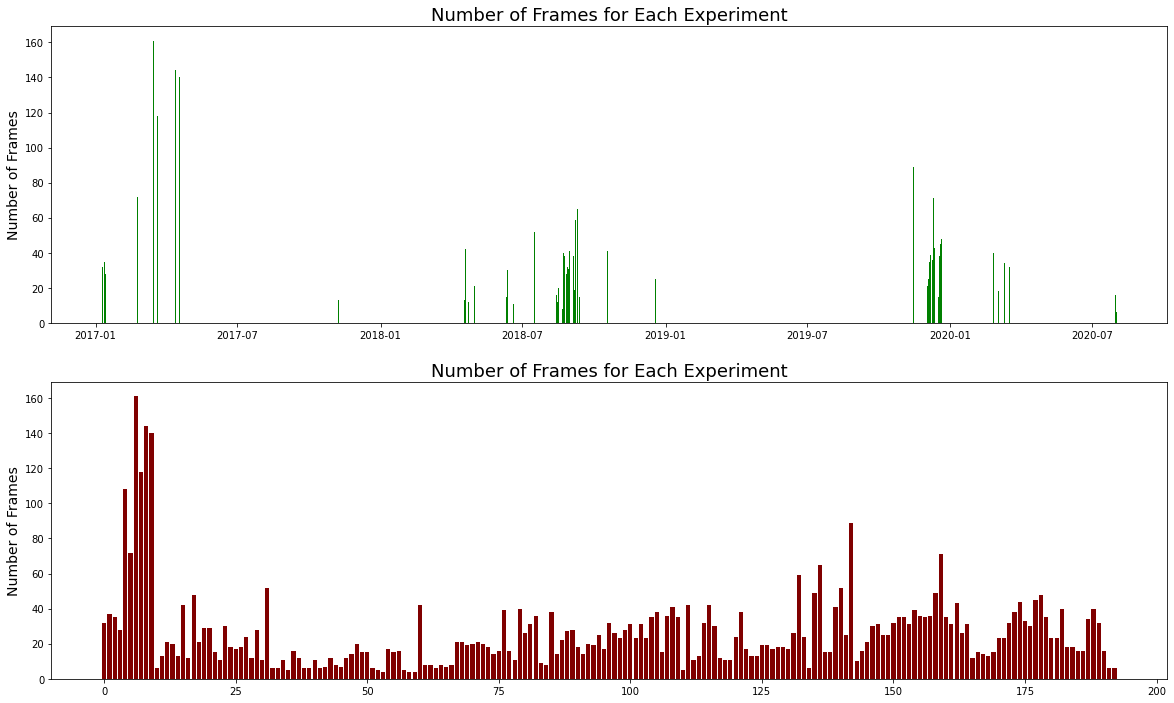

In [ ]:
# ID of various experiments in the database
expID_list = df_exp["expID"].tolist()

fig,ax=plt.subplots(2,1,figsize=(20,12))
ax[0].bar([datetime.fromtimestamp(int(x)) for x in expID_list], df_exp["num_of_frames"], color='green')
ax[0].set_ylabel("Number of Frames", fontsize=14)
#ax[0].set_xticklabels(rotation=30, ha='right')
ax[0].set_title("Number of Frames for Each Experiment", fontsize=18)

ax[1].bar([i for i,x in enumerate(expID_list)], df_exp["num_of_frames"], color='maroon')
ax[1].set_ylabel("Number of Frames", fontsize=14)
#ax[1].set_xticklabels(rotation=30, ha='right')
ax[1].set_title("Number of Frames for Each Experiment", fontsize=18)
plt.show()

In [ ]:
df.head()

,expID,time,hrr,file_path,frame_index,datetime
0,1483987625,0,-1.64,DataFolder/full-heatstamps\1483987625_0_-1.64.jpg,0,2017-01-09 13:47:05
1,1483987625,1000,550.23,DataFolder/full-heatstamps\1483987625_1000_550...,1,2017-01-09 13:47:05
2,1483987625,100,-3.88,DataFolder/full-heatstamps\1483987625_100_-3.8...,2,2017-01-09 13:47:05
3,1483987625,1100,672.20,DataFolder/full-heatstamps\1483987625_1100_672...,3,2017-01-09 13:47:05
4,1483987625,1200,730.44,DataFolder/full-heatstamps\1483987625_1200_730...,4,2017-01-09 13:47:05


# Visualizing the Heat Release Rate for one Experiment (One Video)

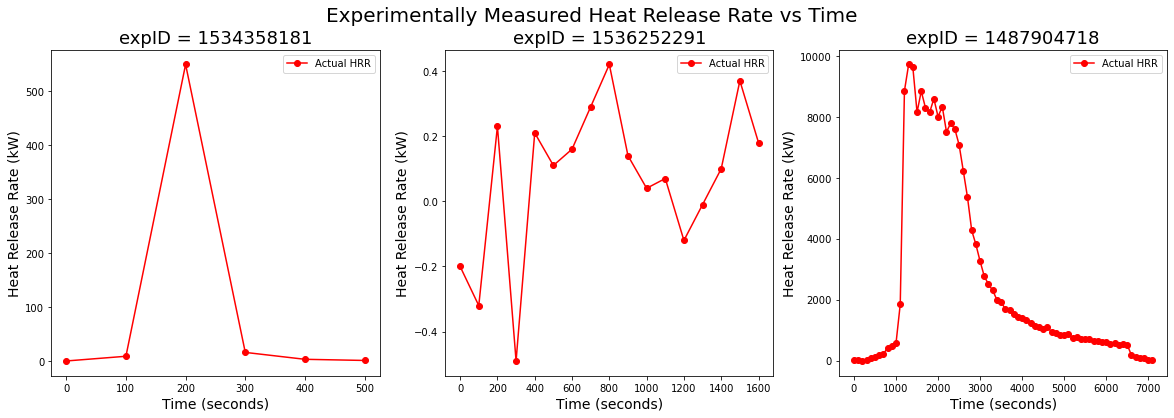

In [ ]:
# Selecting one experiment 
n_figures=3
fig,ax=plt.subplots(1,n_figures,figsize=(20,6))
for i in range(n_figures):
    
    rint = np.random.randint(len(expID_list))

    ax[i].plot(df_exp.iloc[rint].time_list, df_exp.iloc[rint].hrr_list, 'ro-', label="Actual HRR")
    ax[i].set_xlabel("Time (seconds)", fontsize=14)
    ax[i].set_ylabel("Heat Release Rate (kW)", fontsize=14)

    ax[i].set_title(f"expID = {expID_list[rint]}", fontsize=18)
    ax[i].legend()
plt.suptitle("Experimentally Measured Heat Release Rate vs Time", fontsize=20)
plt.show()


In [ ]:
train_df, val_df = train_test_split(df, train_size = 0.8)

In [ ]:
train_df.head()

,expID,time,hrr,file_path,frame_index,datetime
3482,1539886448,3900,5.76,DataFolder/full-heatstamps\1539886448_3900_5.7...,3482,2018-10-18 14:14:08
4885,1582659741,0,-3.41,DataFolder/full-heatstamps\1582659741_0_-3.41.jpg,4885,2020-02-25 14:42:21
2427,1535551693,500,57.35,DataFolder/full-heatstamps\1535551693_500_57.3...,2427,2018-08-29 10:08:13
646,1492091485,1900,5905.90,DataFolder/full-heatstamps\1492091485_1900_590...,646,2017-04-13 09:51:25
1884,1535034614,1500,-0.27,DataFolder/full-heatstamps\1535034614_1500_-0....,1884,2018-08-23 10:30:14


In [ ]:
train_df.dtypes

expID                   int32
time                    int32
hrr                   float64
file_path              object
frame_index             int32
datetime       datetime64[ns]
dtype: object

# Create tf Datasets

In [ ]:
try:
    AUTOTUNE = tf.data.AUTOTUNE
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data  = tf.data.Dataset.from_tensor_slices((train_df.file_path.to_numpy(), train_df.hrr.to_numpy()))

validation_data = tf.data.Dataset.from_tensor_slices((val_df.file_path.to_numpy(), val_df.hrr.to_numpy()))
BATCH_SIZE = 32

size_x = 1080
size_y = 1920

def process_data(file_path, target):

  # read data
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels = 3)

  #resize or pad
  img = tf.image.resize_with_crop_or_pad(img, target_height = size_x, target_width = size_y)

  img = tf.image.resize(img, size = (size_x//2, size_y//2))

  # normalising
  img = tf.cast(img, tf.float32)/255.0
  
  # compress later if needed

  return img, target


train_data = train_data.shuffle(buffer_size = len(train_df))
train_data = train_data.map(process_data, num_parallel_calls = AUTOTUNE)
train_data = train_data.batch(batch_size = BATCH_SIZE)
train_data = train_data.prefetch(buffer_size = AUTOTUNE)


validation_data = validation_data.shuffle(buffer_size = len(val_df))
validation_data = validation_data.map(process_data, num_parallel_calls = AUTOTUNE)
validation_data = validation_data.batch(batch_size = BATCH_SIZE)
validation_data = validation_data.prefetch(buffer_size = AUTOTUNE)

In [ ]:
for image, label in train_data.take(1):
    print(image.shape, label.shape)

(32, 540, 960, 3) (32,)


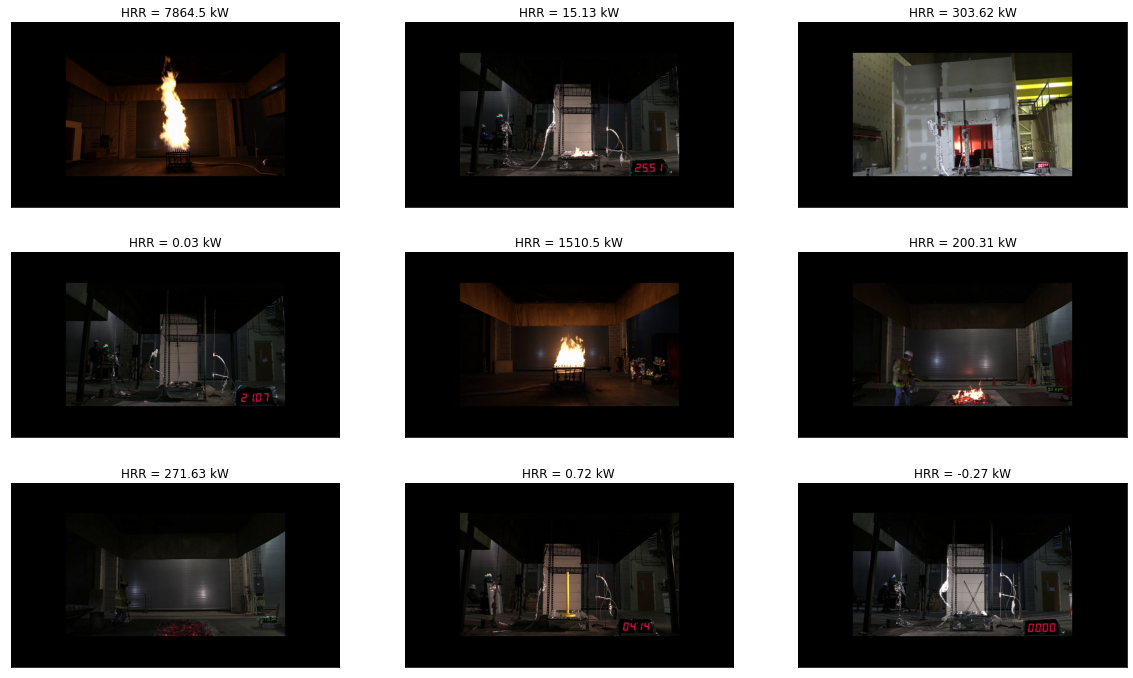

In [ ]:
fig,ax = plt.subplots(3,3, figsize=(20,12))
for i in range(3):
    for j in range(3):
        for image, label in train_data.take(1):
            #print(image.shape, label.shape)
            pass
        
        rint = np.random.randint(BATCH_SIZE)
        ax[i,j].imshow(image.numpy()[rint])
        ax[i,j].set_title(f'HRR = {label.numpy()[rint]} kW')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

# Create a baseline CNN model

In [ ]:
#Normalize the model
n_channels = 3
size_x = 540
size_y = 960
print(f"size_x: {size_x}")
print(f"size_y: {size_y}")

size_x: 540
size_y: 960


In [ ]:
# Reset all states generated by keras
tf.keras.backend.clear_session()

In [ ]:
def define_model(filter):
    #defining the model based on filters
    model = Sequential()
    model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003), input_shape=(size_x, size_y, n_channels)))
    model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.3))
    
    model.add(BatchNormalization())
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.3))
    
    model.add(BatchNormalization())  
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.3))

    model.add(BatchNormalization())  
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.3))
    
    model.add(BatchNormalization())  
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(Conv2D(filter*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.3))
    
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(filter*4, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.003)))
    model.add(Dense(1, activation='linear'))

    # compile model
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
    print(model.summary())
    return model

In [ ]:
cnn_model = define_model(8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 540, 960, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 540, 960, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 270, 480, 8)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 270, 480, 8)      32        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 270, 480, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 270, 480, 16)      2

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode="auto", restore_best_weights = True)
cnn_model_history =  cnn_model.fit(train_data, epochs=40, validation_data=validation_data, callbacks=[early_stopping_callback], verbose=1)

Epoch 1/40
128/128 [==============================] - 1335s 10s/step - loss: 3160238.5000 - mean_absolute_error: 722.8516 - val_loss: 3003947.5000 - val_mean_absolute_error: 661.1064
Epoch 2/40
128/128 [==============================] - 1281s 10s/step - loss: 1637467.3750 - mean_absolute_error: 529.7475 - val_loss: 25788372.0000 - val_mean_absolute_error: 2649.5886
Epoch 3/40
128/128 [==============================] - 1355s 11s/step - loss: 1327769.7500 - mean_absolute_error: 491.6726 - val_loss: 2846725.0000 - val_mean_absolute_error: 910.2982
Epoch 4/40
128/128 [==============================] - 1369s 11s/step - loss: 978419.3125 - mean_absolute_error: 400.5403 - val_loss: 1108166.0000 - val_mean_absolute_error: 530.4191
Epoch 5/40
128/128 [==============================] - 1354s 11s/step - loss: 880819.9375 - mean_absolute_error: 404.6727 - val_loss: 782665.8125 - val_mean_absolute_error: 413.2565
Epoch 6/40
128/128 [==============================] - 1320s 10s/step - loss: 608465.43

In [ ]:
cnn_model.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


In [ ]:
del cnn_model
cnn_model = keras.models.load_model("cnn_model")

Text(0.5, 0.98, 'Model Training : Test Loss and Accuracy')

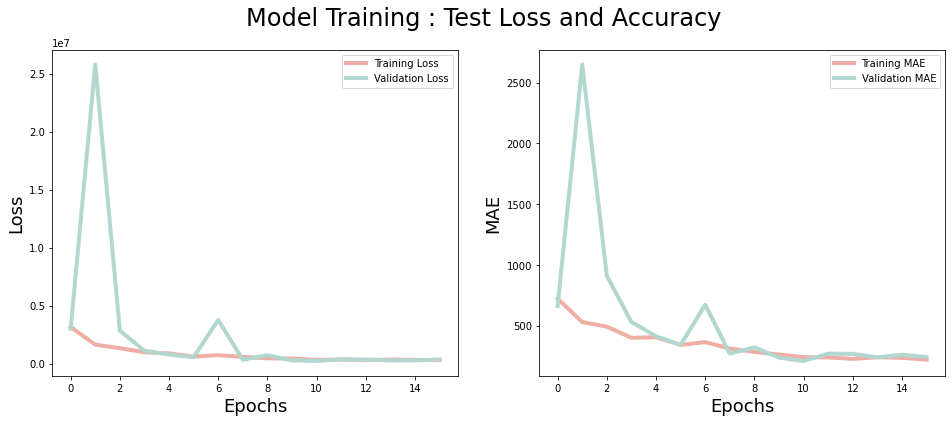

In [ ]:
# learning curves
# plot train and val acc as  a function of epochs
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(cnn_model_history.history['loss'],color='#EFAEA4',label = 'Training Loss',linewidth=4.0)
ax[0].plot(cnn_model_history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss',linewidth=4.0)
ax[1].plot(cnn_model_history.history['mean_absolute_error'],color='#EFAEA4',label = 'Training MAE',linewidth=4.0)
ax[1].plot(cnn_model_history.history['val_mean_absolute_error'],color='#B2D7D0',label = 'Validation MAE',linewidth=4.0)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs', fontsize=18)
ax[1].set_xlabel('Epochs', fontsize=18)
ax[0].set_ylabel('Loss', fontsize=18)
ax[1].set_ylabel('MAE', fontsize=18);
fig.suptitle('Model Training : Test Loss and Accuracy', fontsize = 24)

In [ ]:
try:
    AUTOTUNE = tf.data.AUTOTUNE
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

data  = tf.data.Dataset.from_tensor_slices((df.file_path.to_numpy(), df.hrr.to_numpy()))

BATCH_SIZE = 32

size_x = 1080
size_y = 1920

data = data.map(process_data, num_parallel_calls = AUTOTUNE)
data = data.batch(batch_size = BATCH_SIZE)
data = data.prefetch(buffer_size = AUTOTUNE)

In [ ]:
i=0
for image, label in data:

    y_pred = cnn_model.predict(image)
    y=label.numpy()
    
    if i==0:
        y_pred_all = y_pred.copy()
        y_all = y.copy()
    else:
        y_pred_all = np.append(y_pred_all, y_pred)
        y_all = np.append(y_all, y)
    i+=1
    
print(y_pred_all.shape, y_all.shape)

1/1 [==============================] - 2s 2s/step
(5087,) (5087,)


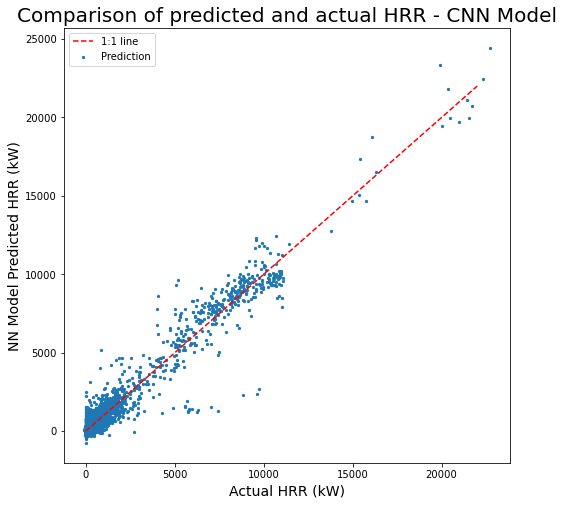

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_all, y_pred_all, label='Prediction', s=5.0)
plt.xlabel("Actual HRR (kW)", fontsize=14)
plt.ylabel("NN Model Predicted HRR (kW)", fontsize=14)
plt.plot([1, 22000], [1, 22000], 'r--', label=('1:1 line'))
plt.title("Comparison of predicted and actual HRR - CNN Model", fontsize=20)
plt.legend()
plt.show()

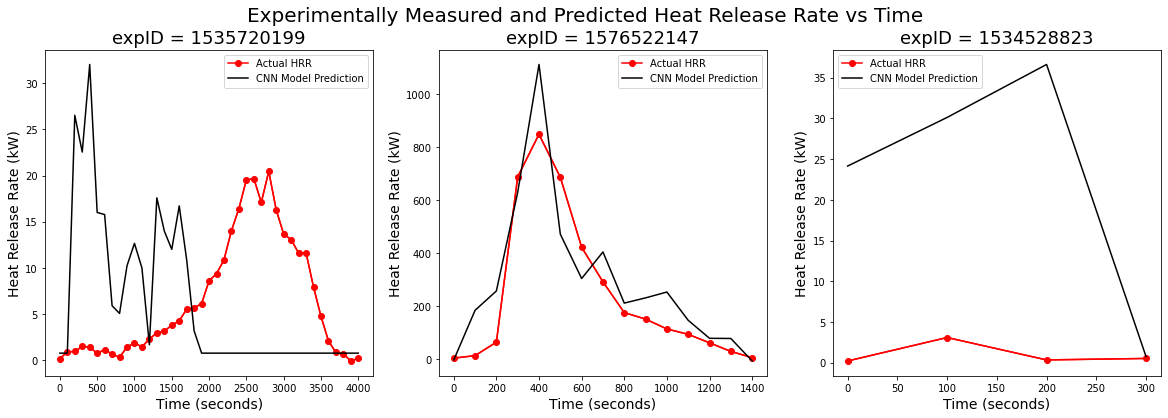

In [ ]:
# Selecting one experiment 
n_figures=3
fig,ax=plt.subplots(1,n_figures,figsize=(20,6))
for i in range(n_figures):
    rint = np.random.randint(len(expID_list))

    ax[i].plot(df_exp.iloc[rint].time_list, df_exp.iloc[rint].hrr_list, 'ro-', label="Actual HRR")
    ax[i].set_xlabel("Time (seconds)", fontsize=14)
    ax[i].set_ylabel("Heat Release Rate (kW)", fontsize=14)

    ind = df_exp.iloc[rint].frameindex_list
    y_ind = [y_all[i] for i in ind]
    ax[i].plot(df_exp.iloc[rint].time_list, y_ind, 'r')

    y_ind = [y_pred_all[i] for i in ind]
    ax[i].plot(df_exp.iloc[rint].time_list, y_ind, 'k', label="CNN Model Prediction")

    ax[i].set_title(f"expID = {expID_list[rint]}", fontsize=18)
    ax[i].legend()
    
plt.suptitle("Experimentally Measured and Predicted Heat Release Rate vs Time", fontsize=20)
plt.show()

In [ ]:
print('CNN Regularized Model Summary')
model_table= PrettyTable()

model_table.field_names = ["Parameter", "Train", "Validation", "Difference (Train-Val)"]
model_table.add_row(["Loss", round(cnn_model_history.history['loss'][-1],2), round(cnn_model_history.history['val_loss'][-1],2), round(cnn_model_history.history['loss'][-1]-cnn_model_history.history['val_loss'][-1],2)])
model_table.add_row(["MAE", round(cnn_model_history.history['mean_absolute_error'][-1],2), round(cnn_model_history.history['val_mean_absolute_error'][-1],2), round(cnn_model_history.history['mean_absolute_error'][-1]-cnn_model_history.history['val_mean_absolute_error'][-1],2)])
print(model_table)

CNN Regularized Model Summary
+-----------+-----------+------------+------------------------+
| Parameter |   Train   | Validation | Difference (Train-Val) |
+-----------+-----------+------------+------------------------+
|    Loss   | 304398.62 | 355411.06  |       -51012.44        |
|    MAE    |   219.84  |   241.47   |         -21.63         |
+-----------+-----------+------------+------------------------+


In [ ]:
# Do we need to normalize the embedding layer
# Reduce the number of embeddings

# Coupling  CNN with RNN model

In [ ]:
def get_embeddings(cnn_model, layer, data):
    input_embedding = cnn_model.inputs
    output_embedding = cnn_model.layers[-layer].output
    model_embedding = Model(inputs = input_embedding, outputs = output_embedding)
    
    i=0
    for image, label in data:
        embed = model_embedding.predict(image)

        if i==0:
            embed_all = embed
            label_all = label.numpy()        
        else:
            embed_all = np.append(embed_all, embed, axis=0)
            label_all = np.append(label_all, label, axis=0)
        i+=1

        
    return embed_all, label_all

## Find the embeddings of the images using the CNN network

In [ ]:
embed, label = get_embeddings(cnn_model, 3, data)

print(embed.shape, type(embed))
print(label.shape, type(label))

len_embedding = embed.shape[1]
print(len_embedding)

1/1 [==============================] - 4s 4s/step
(5087, 1920) <class 'numpy.ndarray'>
(5087,) <class 'numpy.ndarray'>
1920


In [ ]:
np.savetxt('embed.txt', embed, fmt='%f')
np.savetxt('label.txt', label, fmt='%f')
embed_new = np.loadtxt('embed.txt', dtype=float)
label_new = np.loadtxt('label.txt', dtype=float)

In [ ]:
num_of_exp = len(df_exp)
max_seq_length = df_exp.num_of_frames.max()

frame_mask = np.zeros(shape=(num_of_exp, max_seq_length), dtype="bool")
frame_features = np.zeros(shape=(num_of_exp, max_seq_length, len_embedding), dtype="float32")
frame_label = np.zeros(shape=(num_of_exp, max_seq_length, 1), dtype="float32")

for ID in range(len(df_exp)):
    i=0
    for seq in df_exp.iloc[ID].frameindex_list:
        frame_features[ID, i, :] =  embed[seq, :]
        frame_label[ID, i, 0] = label[seq]
        frame_mask[ID, i] = 1
        i+=1   

## Plotting the labels for the various experiments

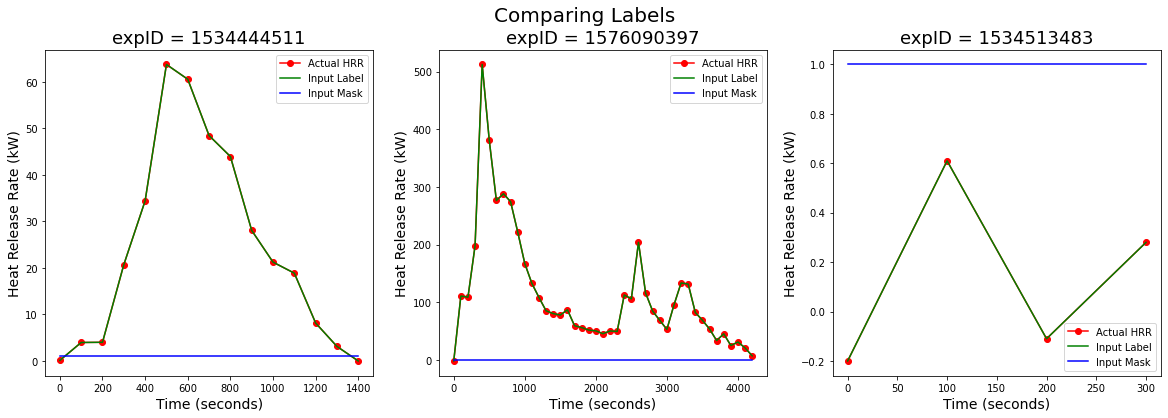

In [ ]:
# Selecting one experiment 
n_figures=3
fig,ax=plt.subplots(1,n_figures,figsize=(20,6))
for i in range(n_figures):
    rint = np.random.randint(len(expID_list))

    ax[i].plot(df_exp.iloc[rint].time_list, df_exp.iloc[rint].hrr_list, 'ro-', label="Actual HRR")
    ax[i].set_xlabel("Time (seconds)", fontsize=14)
    ax[i].set_ylabel("Heat Release Rate (kW)", fontsize=14)

    nframes= df_exp.iloc[rint].num_of_frames
    
    y_ind = frame_label[rint, 0:nframes, 0]
    ax[i].plot(df_exp.iloc[rint].time_list, y_ind, 'g', label="Input Label")
    
    y_ind = frame_mask[rint, 0:nframes]
    ax[i].plot(df_exp.iloc[rint].time_list, y_ind, 'b', label="Input Mask")

    ax[i].set_title(f"expID = {expID_list[rint]}", fontsize=18)
    ax[i].legend()
    
plt.suptitle("Comparing Labels", fontsize=20)
plt.show()

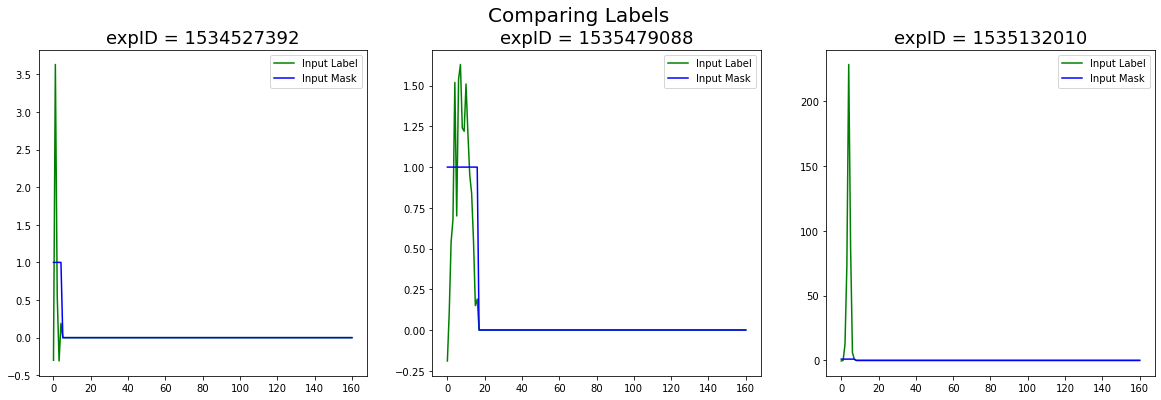

In [ ]:
# Selecting one experiment 
n_figures=3
fig,ax=plt.subplots(1,n_figures,figsize=(20,6))
for i in range(n_figures):
    rint = np.random.randint(len(expID_list))

    nframes= df_exp.iloc[rint].num_of_frames
    
    y_ind = frame_label[rint, :, 0]
    ax[i].plot(y_ind, 'g', label="Input Label")
    
    y_ind = frame_mask[rint, :]
    ax[i].plot(y_ind, 'b', label="Input Mask")

    ax[i].set_title(f"expID = {expID_list[rint]}", fontsize=18)
    ax[i].legend()
    
plt.suptitle("Comparing Labels", fontsize=20)
plt.show()

# Visualizing the Embeddings

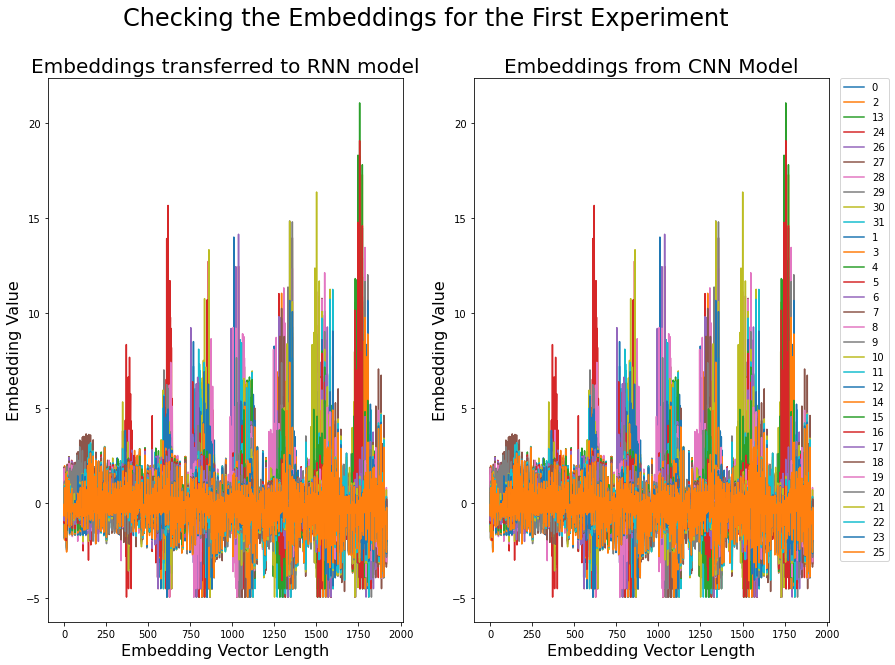

In [ ]:
fig,ax= plt.subplots(1,2,figsize=(14,10))

for ID in range(len(df_exp)):
    i=0
    for seq in df_exp.iloc[ID].frameindex_list:
        ax[0].plot(frame_features[ID, i, :])
        ax[0].set_xlabel("Embedding Vector Length", fontsize=16)
        ax[0].set_ylabel("Embedding Value", fontsize=16)
        ax[0].set_title("Embeddings transferred to RNN model", fontsize=20)
        
        ax[1].plot(embed[seq, :], label=seq)
        ax[1].set_xlabel("Embedding Vector Length", fontsize=16)
        ax[1].set_ylabel("Embedding Value", fontsize=16)
        ax[1].set_title("Embeddings from CNN Model", fontsize=20)
        ax[1].legend(bbox_to_anchor=(1.03,1), loc='upper left', borderaxespad=0)
        i+=1 
    break
plt.suptitle("Checking the Embeddings for the First Experiment", fontsize=24)
plt.show()

In [ ]:
#frame_label = np.expand_dims(frame_label,2)
frame_label.shape

(193, 161, 1)

## Model Type
- Time Distributed Layers
- Simple RNN, 
- GRU
- LSTM

In [ ]:
model_type = "LSTM"

In [ ]:
frame_features_input = Input(shape=(max_seq_length, len_embedding))
mask_input = Input(shape=(max_seq_length,), dtype='bool')

model_type_list = ["Time_Distributed_Layers", "SimpleRNN", "GRU", "LSTM"]
assert model_type in list(set(model_type_list)), "Model not in model list"

if model_type == "Time_Distributed_Layers":
    x = keras.layers.TimeDistributed(Dense(128, activation="relu"))(frame_features_input, mask=mask_input)
    x = keras.layers.TimeDistributed(Dense(4, activation="relu"))(x)
    output = keras.layers.TimeDistributed(Dense(1, activation="linear"))(x)

elif model_type == "SimpleRNN":
    x = keras.layers.SimpleRNN(256, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.SimpleRNN(128, return_sequences=True)(x)
    #x = keras.layers.TimeDistributed(Dropout(0.1))(x)
    #x = keras.layers.TimeDistributed(BatchNormalization())(x)
    x = keras.layers.TimeDistributed(Dense(4, activation="relu"))(x)
    output = keras.layers.TimeDistributed(Dense(1, activation="linear"))(x)
    
elif model_type == "GRU":
    x = keras.layers.GRU(256, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(128, return_sequences=True)(x)
    #x = keras.layers.TimeDistributed(Dropout(0.1))(x)
    #x = keras.layers.TimeDistributed(BatchNormalization())(x)
    x = keras.layers.TimeDistributed(Dense(4, activation="relu"))(x)
    output = keras.layers.TimeDistributed(Dense(1, activation="linear"))(x)

elif model_type == "LSTM":
    x = keras.layers.LSTM(256, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.LSTM(128, return_sequences=True)(x)
    #x = keras.layers.TimeDistributed(Dropout(0.1))(x)
    #x = keras.layers.TimeDistributed(BatchNormalization())(x)
    x = keras.layers.TimeDistributed(Dense(4, activation="relu"))(x)
    output = keras.layers.TimeDistributed(Dense(1, activation="linear"))(x)
else:
    pass

rnn_model = keras.Model([frame_features_input, mask_input], output)   
rnn_model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=["mean_absolute_error"])

In [ ]:
rnn_model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 161, 1920)]  0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 161)]        0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 161, 256)     2229248     ['input_53[0][0]',               
                                                                  'input_54[0][0]']               
                                                                                                  
 lstm_1 (LSTM)                  (None, 161, 128)     197120      ['lstm[0][0]']            

In [ ]:
rnn_model_history = rnn_model.fit([frame_features, frame_mask], frame_label, validation_split=0.2, epochs=50, verbose=0)

Text(0.5, 0.98, 'RNN Model Training : Test Loss and Accuracy')

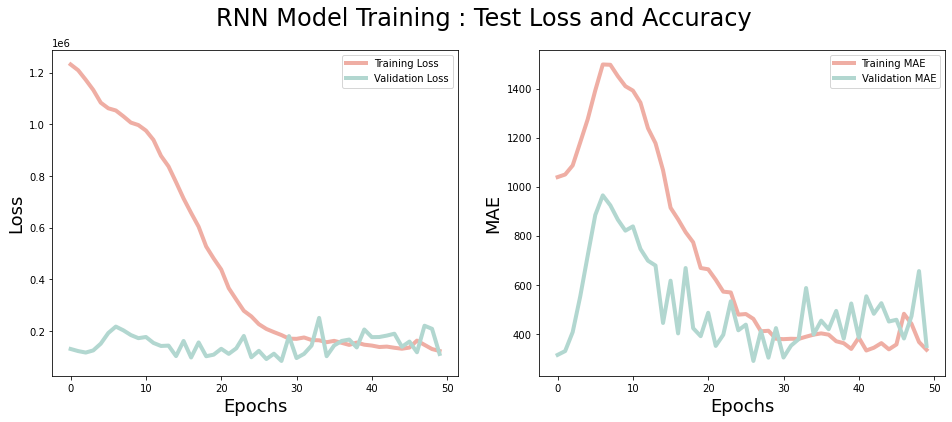

In [ ]:
# learning curves
# plot train and val acc as  a function of epochs
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(rnn_model_history.history['loss'],color='#EFAEA4',label = 'Training Loss',linewidth=4.0)
ax[0].plot(rnn_model_history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss',linewidth=4.0)
ax[1].plot(rnn_model_history.history['mean_absolute_error'],color='#EFAEA4',label = 'Training MAE',linewidth=4.0)
ax[1].plot(rnn_model_history.history['val_mean_absolute_error'],color='#B2D7D0',label = 'Validation MAE',linewidth=4.0)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs', fontsize=18)
ax[1].set_xlabel('Epochs', fontsize=18)
ax[0].set_ylabel('Loss', fontsize=18)
ax[1].set_ylabel('MAE', fontsize=18);
fig.suptitle('RNN Model Training : Test Loss and Accuracy', fontsize = 24)

In [ ]:
rnn_model.save("rnn_model")

INFO:tensorflow:Assets written to: rnn_model\assets


INFO:tensorflow:Assets written to: rnn_model\assets


In [ ]:
del rnn_model
rnn_model = keras.models.load_model("rnn_model")

In [ ]:
y_pred = rnn_model.predict([frame_features, frame_mask])
y=frame_label
print(y_pred.shape, y.shape)

7/7 [==============================] - 8s 643ms/step
(193, 161, 1) (193, 161, 1)


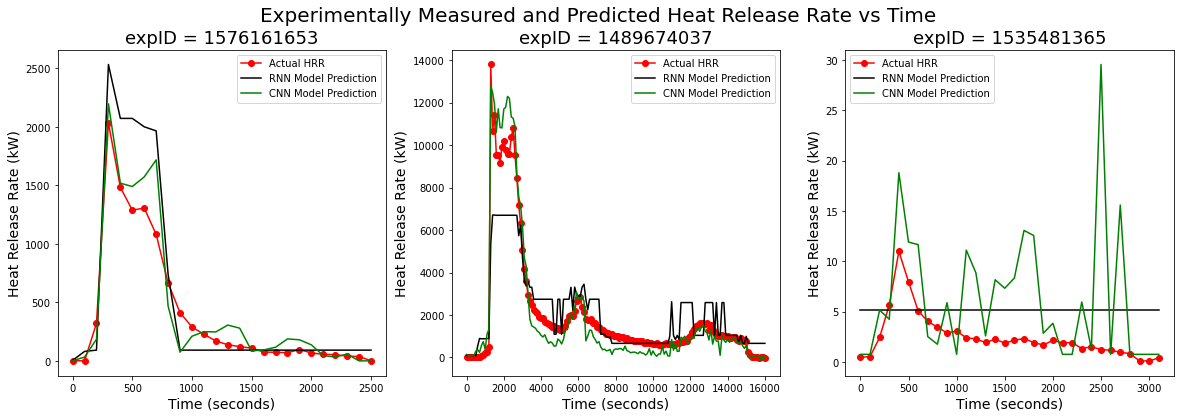

In [ ]:
# Selecting one experiment 
n_figures=3
fig,ax=plt.subplots(1,n_figures,figsize=(20,6))
for i in range(n_figures):
    rint = np.random.randint(len(expID_list))

    ax[i].plot(df_exp.iloc[rint].time_list, df_exp.iloc[rint].hrr_list, 'ro-', label="Actual HRR")
    ax[i].set_xlabel("Time (seconds)", fontsize=14)
    ax[i].set_ylabel("Heat Release Rate (kW)", fontsize=14)

    nframes= df_exp.iloc[rint].num_of_frames
    y_ind = y_pred[rint, :nframes, 0]
    ax[i].plot(df_exp.iloc[rint].time_list, y_ind, 'k', label="RNN Model Prediction")
    
    ind = df_exp.iloc[rint].frameindex_list
    y_ind = [y_pred_all[i] for i in ind]
    ax[i].plot(df_exp.iloc[rint].time_list, y_ind, 'g', label="CNN Model Prediction")

    ax[i].set_title(f"expID = {expID_list[rint]}", fontsize=18)
    ax[i].legend()
    
plt.suptitle("Experimentally Measured and Predicted Heat Release Rate vs Time", fontsize=20)
plt.show()

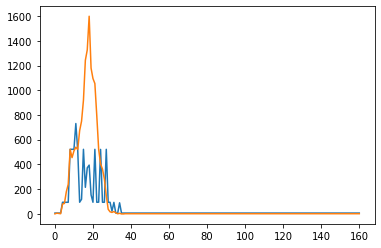

In [ ]:
i=1
plt.plot(y_pred[i])
plt.plot(y[i])